# Old Babylonian Lists of Trees and Wooden Objects

## Introductory text needs updating
This notebook will use data scraped from [DCCLT](http://oracc.org/dcclt) with the notebooks [Save ORACC HTML files](https://github.com/niekveldhuis/Digital-Assyriology/blob/master/Scrape-Oracc/Save%20Oracc%20HTML%20files.ipynb) and [Scrape Oracc](https://github.com/niekveldhuis/Digital-Assyriology/blob/master/Scrape-Oracc/Scrape%20Oracc.ipynb), using the input file [ob_lists_wood.txt](https://github.com/ErinBecker/digital-humanities-phylogenetics/blob/master/data/text_ids/ob_lists_wood.txt). The input file lists all the Text IDs of Old Babylonian lists of trees and wooden objects currently in DCCLT, as well as the composite text of the Nippur version. Text IDs consist of a P plus a six-digit number (commonly referred to as P-number) that is recognized by [ORACC](http://oracc.org) and by [CDLI](http://cdli.ucla.edu) and that has become the de-facto standard in Assyriology. [CDLI](http://cdli.ucla.edu) provides metadata (provenience, period, publication, museum number, etc) for each text.  Composite text IDs consist of a Q plus a six-digit number.

The raw data are placed in the directory [data/raw](https://github.com/ErinBecker/digital-humanities-phylogenetics/tree/master/data/raw). Each text has a separate file named dcclt_P######.txt (or dcclt_Q######.txt). These are comma-separated files with the fields id_text, text_name, l_no, text. 

| field         | description                     |
|-----------	|------------------------------------------------------------------------------------------------------------------------------------------------------	|
| id_line   	| allows creation of a link to the online edition in [DCCLT](http://oracc.org/dcclt) and/or to the images and metadata in [CDLI](http://cdli.ucla.edu) 	|
| label 	| line number: obverse/reverse, column number, line number (e.g. o ii 16')                                                          	|
| lemma      	| Sumerian words in lemmatized form (e.g. lugal[king]N)                                                                                  	|
| base      	|                                                                                                     	|
| extent | |
| scope | |

This data presents a couple of discrete problems with respect to handling missing information. There were several types of missing information, which are handled in different ways.  

| type         | how represented                     |
|-----------	|------------------------------------------------------------------------------------------------------------------------------------------------------	|
| words with unknown translation| eg. siki-siki[NA]NA |
| illegible words | x[NA]NA |
| known number of missing lines 	| |
| unknown number of missing lines	| 
  


In [1]:
import pandas as pd
import numpy as np
import re

# Open File
Open file `obwood.csv` and create a Dataframe in Pandas. 

In [2]:
file = '../data/ob_lists_wood.csv'
df = pd.read_csv(file).drop('Unnamed: 0', axis=1)

In [3]:
df.head(50)

,id_line,label,lemma,base,extent,scope
0,P117395.2,o 1,ŋešed[key]N,{ŋeš}e₃-a,NaN,NaN
1,P117395.3,o 2,pakud[~tree]N,{ŋeš}pa-kud,NaN,NaN
2,P117395.4,o 3,raba[clamp]N,{ŋeš}raba,NaN,NaN
3,P117404.2,o 1,ig[door]N eren[cedar]N,{ŋeš}ig {ŋeš}eren,NaN,NaN
4,P117404.3,o 2,ig[door]N dib[board]N,{ŋeš}ig dib,NaN,NaN
5,P117404.4,o 3,ig[door]N i[oil]N,{ŋeš}ig i₃,NaN,NaN
6,P128345.2,o 1,garig[comb]N siki[hair]N,{ŋeš}ga-rig₂ siki,NaN,NaN
7,P128345.3,o 2,garig[comb]N siki-siki[NA]NA,{ŋeš}ga-rig₂ siki-siki,NaN,NaN
8,P128345.4,o 3,garig[comb]N saŋdu[head]N,{ŋeš}ga-rig₂ saŋ-du,NaN,NaN
9,P224980.4,o i 1,gigir[chariot]N,{ŋeš}gigir,NaN,NaN


# Create Expressions
A line in a lexical text may contain more than one word. Usually a list is divided into sections by keyword, for instance:

| text                	| translation                      	|
|---------------------	|----------------------------------	|
| {ŋeš}gigir          	| chariot                          	|
| {ŋeš}e₂ gigir       	| chariot cabin                    	|
| {ŋeš}e₂ usan₃ gigir 	| storage box for the chariot whip 	|
| {ŋeš}gaba gigir     	| breastwork of a chariot          	|

In the comparison between different versions of the list the individual words are less interesting than the *entries*, that is: the sequence of words in a single line. In order to look at entries (rather than words), words in an entry are connected by underscores (_). Since in this case all words are in Sumerian, the language designation (sux:) is removed from the field `entry`.

In [4]:
df['entry'] = df['lemma']
df['entry'] = df['entry'].str.replace(' ', '_')
df['id_text'] = df['id_line'].str[:7]
df['line'] = [int(re.sub('.+\.', '', line)) for line in df['id_line']] #create a line number for indexing
df.head(50)

,id_line,label,lemma,base,extent,scope,entry,id_text,line
0,P117395.2,o 1,ŋešed[key]N,{ŋeš}e₃-a,NaN,NaN,ŋešed[key]N,P117395,2
1,P117395.3,o 2,pakud[~tree]N,{ŋeš}pa-kud,NaN,NaN,pakud[~tree]N,P117395,3
2,P117395.4,o 3,raba[clamp]N,{ŋeš}raba,NaN,NaN,raba[clamp]N,P117395,4
3,P117404.2,o 1,ig[door]N eren[cedar]N,{ŋeš}ig {ŋeš}eren,NaN,NaN,ig[door]N_eren[cedar]N,P117404,2
4,P117404.3,o 2,ig[door]N dib[board]N,{ŋeš}ig dib,NaN,NaN,ig[door]N_dib[board]N,P117404,3
5,P117404.4,o 3,ig[door]N i[oil]N,{ŋeš}ig i₃,NaN,NaN,ig[door]N_i[oil]N,P117404,4
6,P128345.2,o 1,garig[comb]N siki[hair]N,{ŋeš}ga-rig₂ siki,NaN,NaN,garig[comb]N_siki[hair]N,P128345,2
7,P128345.3,o 2,garig[comb]N siki-siki[NA]NA,{ŋeš}ga-rig₂ siki-siki,NaN,NaN,garig[comb]N_siki-siki[NA]NA,P128345,3
8,P128345.4,o 3,garig[comb]N saŋdu[head]N,{ŋeš}ga-rig₂ saŋ-du,NaN,NaN,garig[comb]N_saŋdu[head]N,P128345,4
9,P224980.4,o i 1,gigir[chariot]N,{ŋeš}gigir,NaN,NaN,gigir[chariot]N,P224980,4


# Group by Document
The `groupby()` function is used to group the data by document. The function `apply(' '.join)` concatenates the text in the `entries` column, separating them with a white space. The Pandas `groupby()` function results in a series, which is then tranformed into a new Dataframe.

In [5]:
df['entry'] = df['entry'].fillna('')
entries_df = df[['id_text', 'line', 'entry']]
#entries_df = entries_df.dropna()
grouped = entries_df['entry'].groupby(entries_df['id_text']).apply(' '.join).reset_index()
by_text_df = pd.DataFrame(grouped)
by_text_df.head()

,id_text,entry
0,P117395,ŋešed[key]N pakud[~tree]N raba[clamp]N
1,P117404,ig[door]N_eren[cedar]N ig[door]N_dib[board]N i...
2,P128345,garig[comb]N_siki[hair]N garig[comb]N_siki-sik...
3,P224980,gigir[chariot]N e[house]N_gigir[chariot]N e[ho...
4,P224986,guza[chair]N_anše[equid]N guza[chair]N_kaskal[...


# Questions for Niek
1) What does the symbol "~" mean in the lemmatization? For example in row number one of the df above "~tree".  
2) Can you explain what's going on with the "line" column? It appears to start at an arbitrary number for each document.  
3) Why do the first several entries in the DTM start with a number? It looks like these are all words that are unlematized. What do the numbers refer to? Is "10[na]_na" different from "11[na]_na"?

# Document Term Matrix
Transform the DataFrame into a Document Term Matrix (DTM) by using CountVecorizer. This function uses a Regular Expression (token_pattern) to indicate how to find the beginning and end of token. In the current Dataframe entries are separated from each other by a white space. The expression `r.[^ ]+` means: any combination of characters, except the space.

The output of the CountVectorizer (`dtm`) is not in a human-readable format. It is transformed into another DataFrame, with `id_text` as index.

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(analyzer='word', token_pattern=r'[^ ]+')
dtm = cv.fit_transform(by_text_df['entry'])
dtm_df = pd.DataFrame(dtm.toarray(), columns = cv.get_feature_names(), index = by_text_df.index.values)
dtm_df.head()

,1(ban₂)[na]na_1(diš)[na]na_sila[unit]n_11[na]na,1(ban₂)[na]na_2(diš)[na]na_sila[unit]n_12[na]na,1(ban₂)[na]na_3(diš)[na]na_sila[unit]n_13[na]na,1(ban₂)[na]na_4(diš)[na]na_sila[unit]n_14[na]na,1(ban₂)[na]na_5(diš)[na]na_sila[unit]n_15[na]na,1(ban₂)[na]na_še[barley]n_10[na]na,10[na]na_še[barley]n_kugbabbar[silver]n,11[na]na_še[barley]n_kugbabbar[silver]n,12[na]na_še[barley]n_kugbabbar[silver]n,13[na]na_še[barley]n_kugbabbar[silver]n,...,šuʾa[stool]n_ašgab[leatherworker]n,šuʾa[stool]n_burgul[stone-cutter]n,šuʾa[stool]n_dus[bathroom]n,šuʾa[stool]n_kaskal[way]n,šuʾa[stool]n_nagar[carpenter]n,šuʾa[stool]n_niŋgula[greatness]n,šuʾa[stool]n_suhsah[sound]n,šuʾa[stool]n_tibira[sculptor]n,šuʾa[stool]n_x[na]na,šuʾura[goose]n
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Analyzing the DTM
There are various ways in which a DTM may be analyzed. Each document may be understood as a vector, which allows for various kinds of computations, such as distance or cosine-similarity. 

It is important to recall that the DTM does not preserve information about the order of entries. In comparing versions of a lexical text we may think of four types of features: 

* presence or absence of entries
* order of entries in a section
* order of sections in the document
* spelling of words

The present DTM can only address the first feature.

It is also important to realize that the documents in this analysis of are of very different length (from 1 to 750 entries), with more than half of the documents 2 lines or less. The composite text from Nippur is by far the longest document and will dominate any comparison

In [7]:
df_length = dtm_df.sum(axis=1)
df_length.describe()

count    106.000000
mean      46.254717
std      128.342923
min        1.000000
25%        3.000000
50%        3.000000
75%       16.250000
max      776.000000
dtype: float64

Note that I'll be doing some analysis in R, whereas Niek will be doing some in Python. We can use both languages in different cells of the same notebook and even pass variables between languages. See tip #21 [here](https://www.dataquest.io/blog/jupyter-notebook-tips-tricks-shortcuts/).

FYI - if you have difficulty running R cells in a Python notebook using rpy2, try installing
rpy2 through conda instead of through pip.  

`conda install -c r rpy2`

In [8]:
import rpy2.ipython
%load_ext rpy2.ipython

# Make sure the R correctly parsed the DTM  
- It looks like R doesn't allow variable names to start with a number, thus all entries starting with a number had "X" added to the beggining of the entry name.  
- R doesn't allow parentheses in variable names, so entries like "1(ban₂)[na]na" parsed as "X1.ban...na.na".   
- 



In [9]:
%%R -i dtm_df
head(dtm_df[,1:10])
#str(dtm_df)

  X1.ban...na.na_1.diš..na.na_sila.unit.n_11.na.na
0                                                0
1                                                0
2                                                0
3                                                0
4                                                0
5                                                0
  X1.ban...na.na_2.diš..na.na_sila.unit.n_12.na.na
0                                                0
1                                                0
2                                                0
3                                                0
4                                                0
5                                                0
  X1.ban...na.na_3.diš..na.na_sila.unit.n_13.na.na
0                                                0
1                                                0
2                                                0
3                                                0
4                              

# Check density of DTM

Look at distribution of document lengths (number of entries per document).  
Look at distribution of entry freqency (number of documents each entry appears in).


   1    2    3    4    5    6    7    8    9   10   11   14   17   18   19   20 
   1    3   56    4    1    2    1    3    1    4    1    2    1    1    1    1 
  22   25   35   36   38   64   93  100  101  109  144  163  167  182  183  214 
   1    1    3    1    1    1    1    1    1    1    1    1    1    1    1    1 
 244  402  666  668  776 <NA> 
   1    1    1    1    1    1 


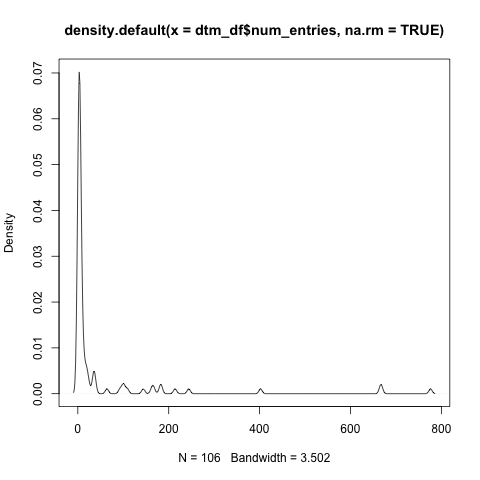

In [10]:
%%R

dtm_df$num_entries = rowSums(dtm_df)
dtm_df["num_occurances",] = colSums(dtm_df)
dtm_df["num_occurances","num_entries"] = NA 

plot(density(dtm_df$num_entries, na.rm = TRUE))
table(dtm_df$num_entries, useNA = "ifany") #number of documents with each number of entries

#length(which(dtm_df$num_entries >= 10))
#length(which(dtm_df$num_entries >= 100))

Only 34 documents have 10 or more entries. Fourteen documents have 100 entries or more.

How frequently do entries re-occur within the corpus?

num_occurances
   1    2    3    4    5    6    7    8    9   10   11   12   13   14   16   17 
1472  297  184  118   77   49   37   25   17    6    6    3    2    2    2    1 
  19   49  189 <NA> 
   1    1    1    1 


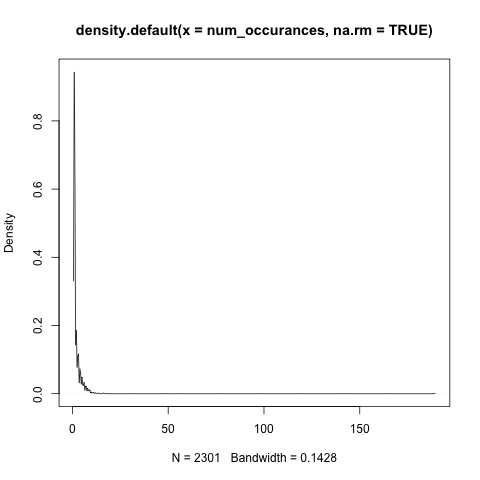

In [11]:
%%R 

num_occurances = unlist(dtm_df["num_occurances",])
plot(density(num_occurances, na.rm = TRUE))
table(num_occurances, useNA = "ifany")


75% of entries appear only once or twice across the corpus. Twenty-five appear in ten or more documents, including one that occurs 189 times across the 106 documents. Not surprisingly, this very common entry is one that has missing information ("X.ŋeš.x.na.na").

In [12]:
%%R

max_occurances = max(dtm_df["num_occurances",], na.rm = TRUE)
#dtm_df[which(dtm_df["num_occurances",] == max_occurances),]
colnames(dtm_df)[which(dtm_df["num_occurances",] == max_occurances)]
#dtm_df["X.ŋeš.x.na.na"]

[1] "X.ŋeš.x.na.na"


Nine of the twenty-five most common entries are missing information.

In [13]:
%%R 
colnames(dtm_df)[which(dtm_df["num_occurances",] >= 10)]

 [1] "al.hoe.n"                      "allanum.oak.n"                
 [3] "dilim.spoon.n"                 "e.house.n_gigir.chariot.n"    
 [5] "ellag.ball.n"                  "gigir.chariot.n"              
 [7] "guza.chair.n_x.na.na"          "hašhur.apple.n"               
 [9] "hašhur.apple.n_kur.mountain.n" "kid.da.twig.n"                
[11] "kur.wood.n"                    "madal.pole.n"                 
[13] "peš.fig.n"                     "sugin.rot.n"                  
[15] "x.x.na.na"                     "x.na.na"                      
[17] "x.na.na_ŋešnimbar.palm.n"      "X.ŋeš.kal.na.na"              
[19] "X.ŋeš.x.x.x.na.na"             "X.ŋeš.x.x.na.na"              
[21] "X.ŋeš.x.na.na"                 "X.ŋeš.x.na.na_apin.plow.n"    
[23] "šagkal.tree.n"                 "šedug.tree.n"                 
[25] "šenu.tree.n"                  


In [14]:
%%R 

# currently "variables" (entries) are sorted alphabetically, would like sorted by frequency
dtm_df = as.matrix((dtm_df > 0) + 0) # Converts to binary presence/absence information
dtm_df = dtm_df[,order(colSums(dtm_df), decreasing = TRUE)]
dtm_df = as.data.frame(dtm_df)

In [15]:
%%R 

# Need to recaculate number of occurances, as was converted to binary. 
dtm_df["num_occurances",] = colSums(dtm_df)
dtm_df["num_occurances","num_entries"] = NA 

num_occurances = unlist(dtm_df["num_occurances",])
table(num_occurances, useNA = "ifany")

num_occurances
   2    3    4    5    6    7    8    9   10   11   12   13   22 <NA> 
1547  270  169  118   69   56   26   25    8    7    4    1    1    1 


I think there's something off here. No entries appear in only one document? But we already know that 1472 entries appear only once across the whole corpus, so there is a problem here.

In [16]:
%%R
# These entries appear in at least 10 different documents.
colnames(dtm_df)[which(dtm_df["num_occurances",] >=10)]

 [1] "X.ŋeš.x.na.na"                  "al.hoe.n"                      
 [3] "hašhur.apple.n"                 "hašhur.apple.n_kur.mountain.n" 
 [5] "peš.fig.n"                      "šedug.tree.n"                  
 [7] "allanum.oak.n"                  "dilim.spoon.n"                 
 [9] "e.house.n_gigir.chariot.n"      "gigir.chariot.n"               
[11] "X.ŋeš.x.x.na.na"                "šagkal.tree.n"                 
[13] "šenu.tree.n"                    "al.hoe.n_zu.tooth.n_min.two.nu"
[15] "lamgal.nut.n"                   "urnum.cedar.n"                 
[17] "ŋeštin.vine.n"                  "ŋeštinguruma..vine.n"          
[19] "ŋeštinkira.berry.n"             "ŋipar.tree.n"                  
[21] "šennur.plum.n"                 


In [17]:
%%R
dtm_df$document = row.names(dtm_df) #add document names as row names
dtm_df = dtm_df[-which(row.names(dtm_df) == "num_occurances"),] # remove num_occurances row

In [18]:
%%R

#install.packages("reshape")
library(reshape)

melted_dtm_df = melt(dtm_df)
head(melted_dtm_df)

//anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Using document as id variables

  warnings.warn(x, RRuntimeWarning)


  document      variable value
1        0 X.ŋeš.x.na.na     0
2        1 X.ŋeš.x.na.na     0
3        2 X.ŋeš.x.na.na     0
4        3 X.ŋeš.x.na.na     0
5        4 X.ŋeš.x.na.na     0
6        5 X.ŋeš.x.na.na     0


In [19]:
%%R 
# http://stackoverflow.com/questions/10397183/heat-map-of-binary-data-using-r-or-python
#install.packages("ggplot2")
library(ggplot2)
# ggplot(data = melted_dtm_df[150000:160474,], aes(y=document, x=variable, fill=value)) + 
#   geom_tile() +
#   theme(axis.text.x = element_text(angle = 90, hjust = 1, size = 5))

#qplot(data=melted_dtm_df, x=variable,y=document, fill=factor(value),
#    geom="tile")+scale_fill_manual(values=c("0"="lightblue", "1"="red")) +
#  theme(axis.text.x = element_text(angle = 90, hjust = 1, size = 1), axis.text.y = element_text(size = 3))

# Look at a subset
# qplot(data = melted_dtm_df[1:10000,], x=variable, y=document, fill=factor(value),
#     geom="tile")+scale_fill_manual(values=c("0"="lightblue", "1"="red")) +
# theme(axis.text.x = element_text(angle = 90, hjust = 1, size = 8), axis.text.y = element_text(size = 5))


# Grouping Documents by Entry Similarity  
We can use hierarchical clustering with our presence/absence matrix to uncover groups of similar documents. Ideally, we can benchmark these clusters' accuracy in uncovering geographically or chronologically related documents by looking at metadata, but for this collection the metadata may be too sparse to do that benchmarking.  

In either case, we can establish a workflow for doing hierarchical clustering and apply that to other datasets with better provenance information to test for cluster utility.  

Troubleshooting note:  
When running R as a magic within Jupyter notebook, running install.packages() leads to the notebook prompting you for a selection. It turns out that this is due to the fact that anaconda actually installs a second R installation and stores installed packages separately from the users "main" R installation.  

To avoid this issue, run '.libPaths()' within R in your console to find the path where anaconda stores your packages. You can then download binaries from CRAN and put them in that directory. 

In [20]:
# See Troubleshooting note above.
# %%R 
# install.packages("ggdendro", "/anaconda/lib/R/library")

In [23]:
%%R
library(ggdendro)
clusters <- hclust(dist(dtm_df))

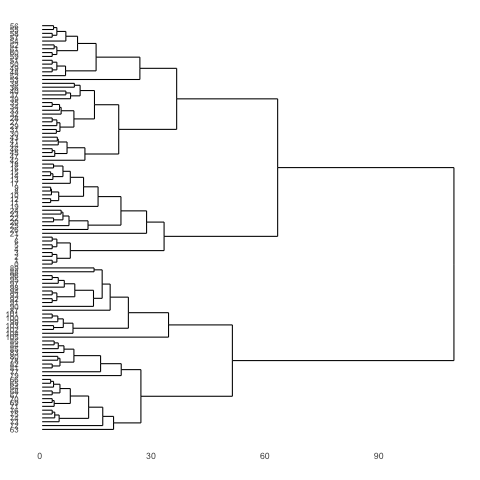

In [30]:
%%R
ggdendrogram(clusters, rotate = TRUE) + theme(axis.text.y = element_text(size = 8))
# Add document names or branches colored by location

In [34]:
%%R 
# Bring in metadata
id_names_equiv_df = read.csv("../data/id_names_equiv_df.csv")
head(id_names_equiv_df)

        id_text              text_name    provenance
1 dcclt/Q000039       OB Nippur Ura 01        Nippur
2 dcclt/P117395    MVN 13 622 [OB Ura] unprovenanced
3 dcclt/P117404    MVN 13 631 [OB Ura] unprovenanced
4 dcclt/P128345 Rochester 248 [OB Ura] unprovenanced
5 dcclt/P224980             TIM 10 001 unprovenanced
6 dcclt/P224986             TIM 10 007 unprovenanced


In [41]:
%%R
head(dtm_df$document)

[1] "0" "1" "2" "3" "4" "5"
